In [1]:
import json
import os

from ost import io
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, auc, precision_recall_curve
import numpy as np

data_dir = os.path.join("..", "data")
plot_dir = os.path.join("..", "data", "plots")

if not os.path.exists(data_dir):
    raise RuntimeError("You need to give me some data")
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
cred = (128.0/255,0.0,0.0)
cblue = (102.0/255,153.0/255,204.0/255)
cgreen = (102.0/255,148.0/255,0.0)
cpurple = (100.0/255,0.0,200.0/255)
corange = (255.0/255,123.0/255,0.0)

# color palette from Jay, originally from https://thenode.biologists.com/data-visualization-with-flying-colors/research/
j_colors = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933', '#CC6677', '#882255', '#AA4499', '#DDDDDD']

# load group mapping
with open("../group_mappings.json", 'r') as fh:
    group_mappings = json.load(fh)
    
# manually add group 248_2
group_mappings["248_2"] = group_mappings["248"] + "_2"


In [2]:
# data loading
df = pd.read_csv("../data/ema_local_scores.csv")
with open("../ema_targets.json", 'r') as fh:
    target_data = json.load(fh)
    
# target_data is a dict with key: target, value: list of target_files
# we're always gonna use the first target file
# The only targets where this will have real implications is
# H1171 and H1172 where we have several slightly different versions
target_data = {k: v[0] for k,v in target_data.items()}

In [6]:
df.columns


Index(['Unnamed: 0', 'mdl', 'trg', 'cname', 'rnum', 'patch_qs', 'patch_dockq',
       'lddt', 'cad', 'global_qs_best', 'global_tm_score', 'n_mdl_chains',
       'true_interface_residue', '283', '098', '426', '002', '086', '248_2',
       '234', '398', '083', '169', '245', '121', '089', '041', '365', '120',
       '101', '126', '275', '298', '282', '248', '168', '494', '158', '468',
       '266'],
      dtype='object')

In [7]:
# This whole code block is only a sanity check to see whether we really have all data...
mdls = set(df["mdl"])
N = 0
missing = list()
for target in target_data.keys():
    model_files = os.listdir("../data/assembly_models/"+target)
    N += len(os.listdir("../data/assembly_models/"+target))
    for mf in model_files:
        if mf not in mdls:
            missing.append(mf)
print("total number of models:", N)
print("missing:", len(missing))
print("mising models:", missing)

# go to the raw json files
mdls_with_errors = list()
mdls_without_interface_residues = list()
for m in missing:
    json_filename = m+'_'
    if m.startswith('T'):
        json_filename += target_data[m[:5]+'o'].split('.')[0]+'.json'
    else:
        json_filename += target_data[m[:5]].split('.')[0]+'.json'
    json_path = "../data/scores/" + json_filename
    with open(json_path) as fh:
        data = json.load(fh)
    if "errors" in data and len(data["errors"]) > 0:
        print(data)
        mdls_with_errors.append(m)
        continue
    n_interface_residues = len(data["interface_residues"])

    if n_interface_residues == 0:
        mdls_without_interface_residues.append(m)
        continue
    print(m)
    raise RuntimeError("shouldnt be here...")
    
print("N models with errors:", len(mdls_with_errors))
print("N models without interface residues:", len(mdls_without_interface_residues))
print("models with errors:", mdls_with_errors)
print("models without interface residues:", mdls_without_interface_residues)
        

total number of models: 11129
missing: 183
mising models: ['H1106TS368_3', 'H1106TS368_2', 'H1106TS333_2', 'H1106TS333_3', 'H1111TS278_1', 'H1111TS215_5', 'H1111TS215_1', 'H1114TS239_1', 'H1114TS229_1', 'H1114TS333_1', 'H1114TS368_1', 'H1129TS333_3', 'H1129TS333_1', 'H1129TS333_4', 'H1129TS368_3', 'H1129TS441_5', 'H1129TS368_4', 'H1129TS333_5', 'H1129TS433_5', 'H1129TS462_2', 'H1129TS333_2', 'H1129TS278_5', 'H1129TS368_1', 'H1129TS368_5', 'H1129TS368_2', 'H1134TS333_1', 'H1134TS368_1', 'H1135TS333_5', 'H1135TS333_2', 'H1135TS368_3', 'H1135TS333_4', 'H1135TS215_4', 'H1135TS333_1', 'H1135TS368_2', 'H1135TS368_5', 'H1135TS368_1', 'H1135TS333_3', 'H1135TS368_4', 'H1140TS368_3', 'H1140TS333_2', 'H1140TS368_1', 'H1140TS333_1', 'H1140TS333_3', 'H1140TS368_5', 'H1140TS333_5', 'H1140TS333_4', 'H1140TS368_4', 'H1140TS368_2', 'H1141TS368_2', 'H1141TS333_3', 'H1141TS333_5', 'H1141TS368_3', 'H1141TS333_2', 'H1141TS368_5', 'H1141TS333_1', 'H1141TS368_4', 'H1141TS333_4', 'H1141TS368_1', 'H1142TS368_1

In [8]:
# filter df - kick out models with different stoichiometry as target
# we're just going for chain count here... 
target_structure_dir = "../data/assembly_targets"
n_trg_chains = dict()
for f in os.listdir(target_structure_dir):
    ent = io.LoadPDB(os.path.join(target_structure_dir, f))
    n_trg_chains[f] = len(ent.chains)

df["n_trg_chains"] = [n_trg_chains[trg] for trg in df["trg"]]
df_filtered = df[df["n_mdl_chains"] == df["n_trg_chains"]]

# report kicked out models (T1192 gets kicked out completely, as the target has wrong stoichiometry)
mdls = set(df["mdl"])
filtered_mdls = set(df_filtered["mdl"])
assert(filtered_mdls.issubset(mdls))
kicked_out_mdls = mdls.difference(filtered_mdls)
kicked_out_mdls = sorted(list(kicked_out_mdls))
print(f"kicked out {len(kicked_out_mdls)} models:", kicked_out_mdls)
print(f"total models:", len(mdls))
print(f"remaining models:", len(filtered_mdls))
print(f"n targets:", len(set(df_filtered["trg"])))

df = df_filtered

residue A.CYS109 contains unknown atom OD1
residue A.CYS109 contains unknown atom OD2
residue A.CYS109 contains unknown atom OD3
residue B.CYS109 contains unknown atom OD1
residue B.CYS109 contains unknown atom OD2
residue B.CYS109 contains unknown atom OD3
residue C.CYS109 contains unknown atom OD1
residue C.CYS109 contains unknown atom OD2
residue C.CYS109 contains unknown atom OD3
residue D.CYS109 contains unknown atom OD1
residue D.CYS109 contains unknown atom OD2
residue D.CYS109 contains unknown atom OD3
residue E.CYS109 contains unknown atom OD1
residue E.CYS109 contains unknown atom OD2
residue E.CYS109 contains unknown atom OD3
residue F.CYS109 contains unknown atom OD1
residue F.CYS109 contains unknown atom OD2
residue F.CYS109 contains unknown atom OD3
residue G.CYS109 contains unknown atom OD1
residue G.CYS109 contains unknown atom OD2
residue G.CYS109 contains unknown atom OD3
residue H.CYS109 contains unknown atom OD1
residue H.CYS109 contains unknown atom OD2
residue H.C

kicked out 617 models: ['H1111TS037_1', 'H1111TS037_2', 'H1111TS037_3', 'H1111TS037_4', 'H1111TS037_5', 'H1111TS092_1', 'H1111TS097_2', 'H1111TS097_3', 'H1111TS097_4', 'H1111TS097_5', 'H1111TS169_1', 'H1111TS169_2', 'H1111TS169_3', 'H1111TS169_4', 'H1111TS169_5', 'H1111TS180_2', 'H1111TS180_3', 'H1111TS180_4', 'H1111TS180_5', 'H1111TS187_1', 'H1111TS187_2', 'H1111TS187_3', 'H1111TS187_4', 'H1111TS187_5', 'H1111TS227_1', 'H1111TS227_2', 'H1111TS227_3', 'H1111TS227_4', 'H1111TS227_5', 'H1111TS245_1', 'H1111TS245_2', 'H1111TS245_3', 'H1111TS245_4', 'H1111TS245_5', 'H1111TS333_1', 'H1111TS333_2', 'H1111TS333_3', 'H1111TS333_4', 'H1111TS333_5', 'H1111TS368_1', 'H1111TS368_2', 'H1111TS368_3', 'H1111TS368_4', 'H1111TS368_5', 'H1111TS385_1', 'H1111TS385_2', 'H1111TS385_3', 'H1111TS385_4', 'H1111TS385_5', 'H1111TS390_1', 'H1111TS390_2', 'H1111TS390_3', 'H1111TS390_4', 'H1111TS390_5', 'H1111TS423_2', 'H1111TS433_1', 'H1111TS433_2', 'H1111TS433_3', 'H1111TS433_4', 'H1111TS433_5', 'H1111TS441_1', 

In [9]:
groups = ['426', '168', '494', '126', '248', '248_2', '266', '083', '282', '120', '468', '101', '234', '245', '002', '098', '298', '041', '158', '398', '121', '089', '169', '365', '283', '275', '086']

In [10]:
# report how many datapoints we have per group
total_data_points = df.shape[0]
print("total datapoints:", total_data_points)
data_points = dict()
for g in groups:
    n = df[df[g].isnull()==False].shape[0]
    print(f"group {g} datapoints: {n}")
    data_points[g] = n
print()
print()
total_per_target_data_points = dict()
per_target_data_points = {g: dict() for g in groups}
for trg, trg_file in target_data.items():
    sub_df = df[df["trg"]==trg_file]
    total_per_target_data_points[trg] = sub_df.shape[0]
    print(f"target {trg} datapoints: {total_per_target_data_points[trg]}")
    for g in groups:
        n = sub_df[sub_df[g].isnull()==False].shape[0]
        per_target_data_points[g][trg] = n
        print(f"group {g} datapoints: {n}")
    print("\n\n")

total datapoints: 3046566
group 426 datapoints: 2026047
group 168 datapoints: 2026047
group 494 datapoints: 2770001
group 126 datapoints: 0
group 248 datapoints: 1874873
group 248_2 datapoints: 2798397
group 266 datapoints: 2997923
group 083 datapoints: 3010847
group 282 datapoints: 0
group 120 datapoints: 0
group 468 datapoints: 2023707
group 101 datapoints: 1396125
group 234 datapoints: 0
group 245 datapoints: 2450644
group 002 datapoints: 0
group 098 datapoints: 0
group 298 datapoints: 0
group 041 datapoints: 2992704
group 158 datapoints: 2430011
group 398 datapoints: 0
group 121 datapoints: 2768374
group 089 datapoints: 2408902
group 169 datapoints: 0
group 365 datapoints: 1833006
group 283 datapoints: 0
group 275 datapoints: 0
group 086 datapoints: 0


target H1106 datapoints: 21143
group 426 datapoints: 21143
group 168 datapoints: 21143
group 494 datapoints: 20292
group 126 datapoints: 0
group 248 datapoints: 10408
group 248_2 datapoints: 20941
group 266 datapoints: 21143
group 0

target T1127o datapoints: 42764
group 426 datapoints: 42764
group 168 datapoints: 42764
group 494 datapoints: 41497
group 126 datapoints: 0
group 248 datapoints: 29185
group 248_2 datapoints: 42343
group 266 datapoints: 42764
group 083 datapoints: 42764
group 282 datapoints: 0
group 120 datapoints: 0
group 468 datapoints: 42764
group 101 datapoints: 41196
group 234 datapoints: 0
group 245 datapoints: 42764
group 002 datapoints: 0
group 098 datapoints: 0
group 298 datapoints: 0
group 041 datapoints: 42764
group 158 datapoints: 41893
group 398 datapoints: 0
group 121 datapoints: 41497
group 089 datapoints: 42255
group 169 datapoints: 0
group 365 datapoints: 42764
group 283 datapoints: 0
group 275 datapoints: 0
group 086 datapoints: 0



target H1129 datapoints: 23377
group 426 datapoints: 23341
group 168 datapoints: 23341
group 494 datapoints: 15312
group 126 datapoints: 0
group 248 datapoints: 16203
group 248_2 datapoints: 22545
group 266 datapoints: 23377
group 083 datapoints: 23377
gr

target T1153o datapoints: 7240
group 426 datapoints: 7240
group 168 datapoints: 7240
group 494 datapoints: 6655
group 126 datapoints: 0
group 248 datapoints: 3883
group 248_2 datapoints: 7157
group 266 datapoints: 7240
group 083 datapoints: 7240
group 282 datapoints: 0
group 120 datapoints: 0
group 468 datapoints: 7240
group 101 datapoints: 6592
group 234 datapoints: 0
group 245 datapoints: 7240
group 002 datapoints: 0
group 098 datapoints: 0
group 298 datapoints: 0
group 041 datapoints: 7240
group 158 datapoints: 7205
group 398 datapoints: 0
group 121 datapoints: 6655
group 089 datapoints: 7120
group 169 datapoints: 0
group 365 datapoints: 7131
group 283 datapoints: 0
group 275 datapoints: 0
group 086 datapoints: 0



target H1157 datapoints: 33710
group 426 datapoints: 33710
group 168 datapoints: 33710
group 494 datapoints: 30314
group 126 datapoints: 0
group 248 datapoints: 21270
group 248_2 datapoints: 33552
group 266 datapoints: 33710
group 083 datapoints: 33710
group 282 datapoin

target T1176o datapoints: 41697
group 426 datapoints: 41473
group 168 datapoints: 41473
group 494 datapoints: 37974
group 126 datapoints: 0
group 248 datapoints: 25041
group 248_2 datapoints: 41697
group 266 datapoints: 41695
group 083 datapoints: 41695
group 282 datapoints: 0
group 120 datapoints: 0
group 468 datapoints: 41473
group 101 datapoints: 38602
group 234 datapoints: 0
group 245 datapoints: 13625
group 002 datapoints: 0
group 098 datapoints: 0
group 298 datapoints: 0
group 041 datapoints: 41695
group 158 datapoints: 39737
group 398 datapoints: 0
group 121 datapoints: 37974
group 089 datapoints: 41320
group 169 datapoints: 0
group 365 datapoints: 0
group 283 datapoints: 0
group 275 datapoints: 0
group 086 datapoints: 0



target T1178o datapoints: 42523
group 426 datapoints: 42523
group 168 datapoints: 42523
group 494 datapoints: 41288
group 126 datapoints: 0
group 248 datapoints: 29753
group 248_2 datapoints: 42173
group 266 datapoints: 42523
group 083 datapoints: 42523
group

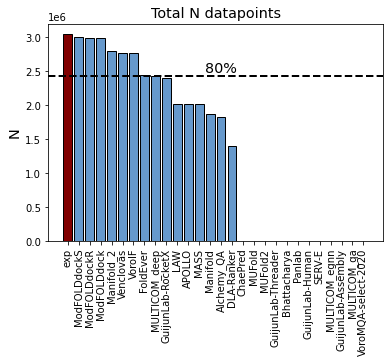

In [11]:
# plot data situation on full datapoints

# the reference...
plt.bar([0], [total_data_points], color=cred, linewidth=1.0, edgecolor='k')

# data from groups
tmp = [(data_points[g],g) for g in groups]
tmp.sort(reverse=True)
sorted_data_points = [x[0] for x in tmp]
sorted_groups = [x[1] for x in tmp]
sorted_groups_names = [group_mappings[x] for x in sorted_groups]
x = list(range(1, len(sorted_groups)+1))
plt.bar(x, sorted_data_points, color=cblue, linewidth=1.0, edgecolor='k')

# plot 80% line
plt.axhline(0.8*total_data_points, linestyle='--', linewidth=2.0, color='k')
plt.text((len(sorted_data_points)+1)/2, 0.8*total_data_points,"80%", fontsize="x-large", verticalalignment="bottom",horizontalalignment="center")

plt.ylabel("N", fontsize="x-large")
plt.title("Total N datapoints", fontsize="x-large")
plt.xticks([0] + x, ["exp"] + sorted_groups_names, rotation=90)
plt.savefig(os.path.join(plot_dir, "local_data_points.png"), dpi=300, bbox_inches="tight")

groups considered for further evaluation: ['266', '083', '041', '248_2', '158', '089', '494', '468', '426', '168', '121', '245', '101']


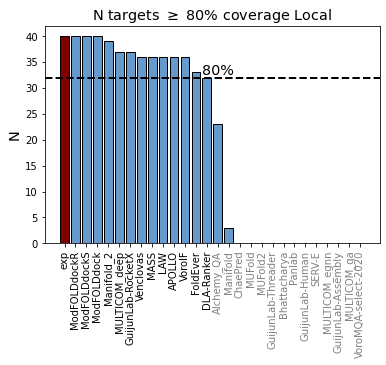

In [12]:
# plot data situation on a per-target basis

# the reference...
N = sum([1 for x in total_per_target_data_points.values() if x > 0])
plt.bar([0], [N], color=cred, linewidth=1.0, edgecolor='k')

# data from groups - count how many targets have > 80% of datapoints
counts = {g: 0 for g in groups}
for g in groups:
    for trg, tot in total_per_target_data_points.items():
        if tot == 0:
            fraction = 0.0 # happens for T1192o
        else:
            fraction = float(per_target_data_points[g][trg])/tot
        if fraction > 0.8:
            counts[g] += 1

tmp = [(counts[g],g) for g in groups]
tmp.sort(reverse=True)
sorted_data_points = [x[0] for x in tmp]
sorted_groups = [x[1] for x in tmp]
sorted_groups_names = [group_mappings[x] for x in sorted_groups]
x = list(range(1, len(sorted_groups)+1))
plt.bar(x, sorted_data_points, color=cblue, linewidth=1.0, edgecolor='k')

# plot 80% line
plt.axhline(0.8*N, linestyle='--', linewidth=2.0, color='k')
plt.text((len(sorted_data_points)+1)/2, 0.8*N,"80%", fontsize="x-large", verticalalignment="bottom",horizontalalignment="center")

sorted_groups_names = ["exp"] + sorted_groups_names
tick_colors = ['k']
for data_point in sorted_data_points:
    if data_point < 0.8*N:
        tick_colors.append('0.5')
    else:
        tick_colors.append('k')

plt.xticks([0] + x, sorted_groups_names, rotation=90)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), tick_colors):
    ticklabel.set_color(tickcolor)

plt.ylabel("N", fontsize="x-large")
plt.title(r"N targets $\geq$ 80% coverage Local", fontsize="x-large")
plt.savefig(os.path.join(plot_dir, "local_data_points_per_target.png"), dpi=300, bbox_inches="tight")

# And here's what we want for further processing
eval_groups = [g for g,c in zip(sorted_groups, sorted_data_points) if c >= 0.8*N]
print("groups considered for further evaluation:", eval_groups)

In [13]:
# evaluation metrics
def adaptive_rocauc(df, target, pred):
    """ Returns ROC AUC with an adaptive class threshold
    
    Adaptive in a sense that the top quantile according target
    is considered positive.
    """
    thresh = df[target].quantile(0.75)
    sub_df = df[(df[target].isnull() == False) & (df[pred].isnull() == False)]
    target_classes = [int(x>thresh) for x in sub_df[target]]
    return max(0.5, roc_auc_score(target_classes, sub_df[pred]))

def pearson_corr(df, target, pred):
    """ Returns pearson correlation
    """
    return df[target].corr(df[pred], method="pearson")

def spearman_corr(df, target, pred):
    """ Returns spearman correlation
    """
    return df[target].corr(df[pred], method="spearman")

In [14]:
def per_target_eval(df, target, eval_groups,
                    target_data, filter_target, filter_target_thresh,
                    metrics={"pearson_r": pearson_corr,
                             "spearman_r": spearman_corr,
                             "roc_auc": adaptive_rocauc}):
    """ Returns DataFrame with one row per target
    
    For each target, each group is evaluated against specified metrics
    (default: pearson_r, spearman_r, roc_auc)
    
    So let's say you have one target (x) and one group (y), you'll get the 
    following columns: x, y_pearson_r, y_spearman_r, y_roc_auc
    
    :param df: The overall per-model DataFrame
    :type df: :class:`DataFrame`
    :param target: The target value, e.g. lddt, cad, patch_qs, patch_dockq
    :type target: :class:`str`
    :param eval_groups: List of groups that are evaluated (y in example above)
    :type eval_groups: :class:`list` of :class:`str`
    :param target_data: Dictionary used in overall evaluation, i.e. trg name as key
                        and respective target file as value
    :type target_data: :class:`dict`
    :param filter_target: Target value used for filtering, i.e. target will be skipped if 
                          no model has the respective value above *filter_target_thresh*
                          (e.g. tm_score, qs_best, etc.)
    :type filter_target: :class:`str`
    :param filter_target_thresh: Threshold for specified *filter_target*
    :type filter_target_tresh: :class:`float`
    :param metrics: Evaluation metrics... shouldn't be changed...
    :type metrics: :class:`dict`
    """
    data = {"trg": list()}
    for g in eval_groups:
        for m in metrics.keys():
            data[g + "_" + m] = list()
    for trg, trg_file in target_data.items():
        sub_df = df[df["trg"] == trg_file]
        # skip targets that have been filtered out completely in preprocessing (happens for T1192o)
        if sub_df.shape[0] == 0:
            print(f"no data for {trg}... skip...")
            continue
        # per-target evaluation only assesses targets which fulfill very crude
        # quality filter, e.g. max QS-score of any of the models > 0.6
        if sub_df[filter_target].max() < filter_target_thresh:
            print("skip trg", trg)
            continue
        data["trg"].append(trg)
        for g in eval_groups:
            n_exp = sub_df.shape[0]
            n_pred = sub_df[sub_df[g].isnull()==False].shape[0]
            if float(n_pred)/n_exp < 0.8:
                # not enough predictions for g
                for m in metrics.keys():
                    data[g + "_" + m].append(None)
            else:
                for m,f in metrics.items():
                    data[g + "_" + m].append(f(sub_df, target, g))
    return pd.DataFrame.from_dict(data)

def per_group_eval(per_target_df, eval_groups,
                   metrics=["pearson_r", "spearman_r", "roc_auc"]):
    """ Takes per_target evaluation with respect to one target value (e.g. tm_score)
    and returns DataFrame with per group averages
    
    So lets say you have one group x, you'll get a DataFrame with the following columns:
    x, pearson_r, spearman_r, roc_auc where the evaluation metrics represent the
    per-target averages.
    
    :param per_target_df: Return value of :func:`per_target_eval`
    :type per_target_df: :class:`DataFrame`
    :param eval_groups: List of groups that are evaluated, must be consistent with what
                        you give :func:`per_target_eval`
    :type eval_groups: :class:`list` of :class:`str`
    :param metrics: Metrics you evaluate with, must be consistent with what you give
                    :func:`per_target_eval`
    :type metrics: :class:`list` of :class:`str`
    """
    data = {"group": list()}
    for m in metrics:
        data[m] = list()
    for g in eval_groups:
        data["group"].append(g)
        for m in metrics:
            data[m].append(per_target_df[f"{g}_{m}"].mean())
    return pd.DataFrame.from_dict(data)

In [15]:
from scipy.stats import zscore

def get_zscore_df(df, target, eval_groups, target_data):
    per_target_df = per_target_eval(df, target, eval_groups, target_data, "global_qs_best", 0.6)
    per_group_df = per_group_eval(per_target_df, eval_groups)

    z_per_group_df = per_group_df.copy()
    numeric_cols = z_per_group_df.select_dtypes(include=[np.number]).columns
    for nc in numeric_cols:
        z_per_group_df[nc] = zscore(z_per_group_df[nc])

    # don't punish for abysmal performance => set negative z-scores to 0.0
    num = z_per_group_df._get_numeric_data()
    num[num < 0] = 0
    
    return (z_per_group_df, per_group_df, per_target_df)

lddt_z_df, lddt_per_group_df, lddt_per_target_df = get_zscore_df(df, "lddt", eval_groups, target_data)
cad_z_df, cad_per_group_df, cad_per_target_df = get_zscore_df(df, "cad", eval_groups, target_data)
patch_qs_z_df, patch_qs_per_group_df, patch_qs_per_target_df = get_zscore_df(df, "patch_qs", eval_groups, target_data)
patch_dockq_z_df, patch_dockq_per_group_df, patch_dockq_per_target_df = get_zscore_df(df, "patch_dockq", eval_groups, target_data)


skip trg T1176o
no data for T1192o... skip...
skip trg T1176o
no data for T1192o... skip...
skip trg T1176o
no data for T1192o... skip...
skip trg T1176o
no data for T1192o... skip...


In [16]:
# dump tables for external analysis
lddt_to_dump = lddt_per_group_df.copy()
lddt_to_dump["group"] = [group_mappings[g] for g in lddt_to_dump["group"]]
lddt_to_dump.to_csv("../data/tables/Local_tables/lDDT_per_target_averages.csv")

cad_to_dump = cad_per_group_df.copy()
cad_to_dump["group"] = [group_mappings[g] for g in cad_to_dump["group"]]
assert(cad_to_dump["group"].equals(lddt_to_dump["group"]))
cad_to_dump.to_csv("../data/tables/Local_tables/CAD_per_target_averages.csv")

patch_qs_to_dump = patch_qs_per_group_df.copy()
patch_qs_to_dump["group"] = [group_mappings[g] for g in patch_qs_to_dump["group"]]
assert(patch_qs_to_dump["group"].equals(lddt_to_dump["group"]))
patch_qs_to_dump.to_csv("../data/tables/Local_tables/PatchQS_per_target_averages.csv")

patch_dockq_to_dump = patch_dockq_per_group_df.copy()
patch_dockq_to_dump["group"] = [group_mappings[g] for g in patch_dockq_to_dump["group"]]
assert(patch_qs_to_dump["group"].equals(lddt_to_dump["group"]))
patch_dockq_to_dump.to_csv("../data/tables/Local_tables/PatchDockQ_per_target_averages.csv")

# now the per-target tables
lddt_per_target_df.to_csv("../data/tables/Local_tables/lDDT_per_target.csv")
cad_per_target_df.to_csv("../data/tables/Local_tables/CAD_per_target.csv")
patch_qs_per_target_df.to_csv("../data/tables/Local_tables/PatchQS_per_target.csv")
patch_dockq_per_target_df.to_csv("../data/tables/Local_tables/PatchDockQ_per_target.csv")

In [17]:
# dump tables for predictioncenter results
def predictioncenter_table(per_target_df, eval_groups, group_mapping, 
                           metrics=["pearson_r", "spearman_r", "roc_auc"]):
    """ Takes per target evaluation and returns Andriy approved dataframe
    
    :param per_target_df: Return value of :func:`per_target_eval`
    :type per_target_df: :class:`DataFrame`
    :param eval_groups: List of groups that are evaluated, must be consistent with what
                        you give :func:`per_target_eval`
    :type eval_groups: :class:`list` of :class:`str`
    :param group_mapping: Mapping where you can request group name given group id from *eval_groups*
    :type group_mapping: :class:`dict`
    :param metrics: Metrics you evaluate with, must be consistent with what you give
                    :func:`per_target_eval`
    :type metrics: :class:`list` of :class:`str`
    """
    data = {"target": list(),
            "group_id": list(),
            "group_name": list()}
    for m in metrics:
        data[m] = list()
        
    # do the average
    for g in eval_groups:
        data["group_id"].append(g)
        data["group_name"].append(group_mapping[g])
        data["target"].append("avg")
        for m in metrics:
            data[m].append(per_target_df[f"{g}_{m}"].mean())
    
    # do per-target
    for t in per_target_df["trg"]:
        sub_df = per_target_df[per_target_df["trg"]==t]
        for g in eval_groups:
            data["group_id"].append(g)
            data["group_name"].append(group_mapping[g])
            data["target"].append(t)
            for m in metrics:
                data[m].append(sub_df[f"{g}_{m}"].iat[0])

    return pd.DataFrame.from_dict(data)

In [18]:
lddt_predictioncenter_df = predictioncenter_table(lddt_per_target_df, eval_groups, group_mappings)
lddt_predictioncenter_df.to_csv("../data/tables/Local_tables/predictioncenter_lddt.csv")

cad_predictioncenter_df = predictioncenter_table(cad_per_target_df, eval_groups, group_mappings)
cad_predictioncenter_df.to_csv("../data/tables/Local_tables/predictioncenter_cad.csv")

patch_qs_predictioncenter_df = predictioncenter_table(patch_qs_per_target_df, eval_groups, group_mappings)
patch_qs_predictioncenter_df.to_csv("../data/tables/Local_tables/predictioncenter_patch_qs.csv")

patch_dockq_predictioncenter_df = predictioncenter_table(patch_dockq_per_target_df, eval_groups, group_mappings)
patch_dockq_predictioncenter_df.to_csv("../data/tables/Local_tables/predictioncenter_patch_dockq.csv")

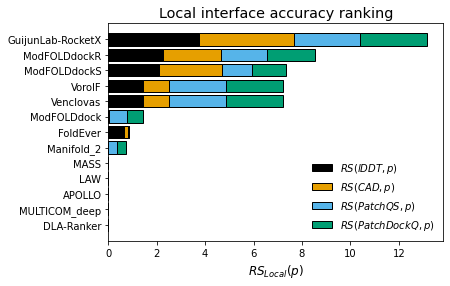

In [19]:
lddt_score = np.array(0.5*lddt_z_df["pearson_r"] + 0.5*lddt_z_df["spearman_r"] + lddt_z_df["roc_auc"])
cad_score = np.array(0.5*cad_z_df["pearson_r"] + 0.5*cad_z_df["spearman_r"] + cad_z_df["roc_auc"])
patch_qs_score = np.array(0.5*patch_qs_z_df["pearson_r"] + 0.5*patch_qs_z_df["spearman_r"] + patch_qs_z_df["roc_auc"])
patch_dockq_score = np.array(0.5*patch_dockq_z_df["pearson_r"] + 0.5*patch_dockq_z_df["spearman_r"] + patch_dockq_z_df["roc_auc"])
groups = list(lddt_z_df["group"])

tmp = [(a+b+c+d,a,b,c,d,e) for a,b,c,d,e in zip(lddt_score, cad_score, patch_qs_score, patch_dockq_score, groups)]
tmp.sort()

sorted_per_target_lddt = [x[1] for x in tmp]
sorted_per_target_cad = [x[2] for x in tmp]
sorted_per_target_patch_qs = [x[3] for x in tmp]
sorted_per_target_patch_dockq = [x[4] for x in tmp]
sorted_per_target_groups = [x[5] for x in tmp]
sorted_per_target_groups_names = [group_mappings[x] for x in sorted_per_target_groups]

# stolen from http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plt.clf()
y = list(range(len(sorted_per_target_groups)))

# do lDDT
left = [0] * len(sorted_per_target_groups)
plt.barh(y, sorted_per_target_lddt, left=left, color=colors[0], linewidth=1.0, edgecolor='k', label="$RS(lDDT, p)$")

# do CAD
left = [a+b for a,b in zip(left, sorted_per_target_lddt)]
plt.barh(y, sorted_per_target_cad, left=left, color=colors[1], linewidth=1.0, edgecolor='k', label="$RS(CAD, p)$")

# do PatchQS
left = [a+b for a,b in zip(left, sorted_per_target_cad)]
plt.barh(y, sorted_per_target_patch_qs, left=left, color=colors[2], linewidth=1.0, edgecolor='k', label="$RS(PatchQS, p)$")

# do PatchDockQ
left = [a+b for a,b in zip(left, sorted_per_target_patch_qs)]
plt.barh(y, sorted_per_target_patch_dockq, left=left, color=colors[3], linewidth=1.0, edgecolor='k', label="$RS(PatchDockQ, p)$")

plt.title("Local interface accuracy ranking", fontsize="x-large")
plt.yticks(y, sorted_per_target_groups_names)
plt.xlabel("$RS_{Local}(p)$", fontsize = "large")
plt.legend(frameon=False, loc='lower right')
plt.savefig(os.path.join(plot_dir, f"local_zscore_ranking.png"), dpi=300, bbox_inches="tight")


0.7127853806698473


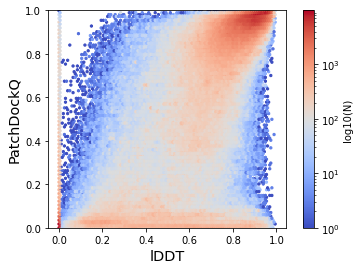

In [20]:
plt.clf()
plt.hexbin('lddt', 'patch_dockq', data=df, bins='log', cmap='coolwarm')
#plt.hexbin('lddt', 'patch_dockq', data=df)
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("lDDT", fontsize="x-large")
plt.ylabel("PatchDockQ", fontsize="x-large")
plt.colorbar(label="log10(N)")
print(df["lddt"].corr(df["patch_dockq"], method="pearson"))
plt.savefig("/home/schdaude/workspace/casp15_ema/data/plots/lddt_vs_patchdockq.png", dpi=300)


0.6366817661526505


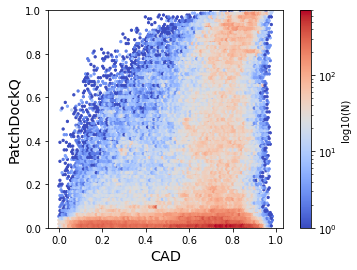

In [22]:
plt.clf()
sub_df = df[df["true_interface_residue"]==False]
plt.hexbin('cad', 'patch_dockq', data=sub_df, bins='log', cmap='coolwarm')
#plt.hexbin('lddt', 'patch_dockq', data=df)
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("CAD", fontsize="x-large")
plt.ylabel("PatchDockQ", fontsize="x-large")
plt.colorbar(label="log10(N)")
print(df["cad"].corr(df["patch_dockq"], method="pearson"))
plt.savefig("/home/schdaude/workspace/casp15_ema/data/plots/cad_vs_patchdockq.png", dpi=300)

In [24]:
sub_df = df[(df["cad"]>0.9)&(df["patch_dockq"]<0.05)]
sub_df

Unnamed: 0            mdl         trg cname  rnum  patch_qs  \
45               45   H1106TS098_3   H1106.pdb     B    67       0.0   
955             955   H1106TS434_5   H1106.pdb     A   114       0.0   
11018         11018   H1106TS398_4   H1106.pdb     B    51       0.0   
11030         11030   H1106TS398_4   H1106.pdb     B    88       0.0   
11033         11033   H1106TS398_4   H1106.pdb     B    97       0.0   
...             ...            ...         ...   ...   ...       ...   
3218144     3218144  T1187TS398_1o  T1187o.pdb     A    65       0.0   
3218156     3218156  T1187TS398_1o  T1187o.pdb     A   122       0.0   
3218171     3218171  T1187TS398_1o  T1187o.pdb     B    58       0.0   
3218172     3218172  T1187TS398_1o  T1187o.pdb     B    61       0.0   
3218190     3218190  T1187TS398_1o  T1187o.pdb     B   160       0.0   

         patch_dockq   lddt    cad  global_qs_best  ...  275  298  282  248  \
45             0.033  0.817  0.905           0.004  ...  NaN  NaN  NaN  NaN   
955            0.037  0.820  0.907           0.814  ...  NaN  NaN  NaN  0.0   
11018          0.035  0.787  0.906           0.052  ...  NaN  NaN  NaN  1.0   
11030          0.031  0.894  0.936           0.052  ...  NaN  NaN  NaN  0.0   
11033          0.030  0.859  0.954           0.052  ...  NaN  NaN  NaN  NaN   
...              ...    ...    ...             ...  ...  ...  ...  ...  ...   
3218144        0.015  0.927  0.910           0.000  ...  NaN  NaN  NaN  NaN   
3218156        0.014  0.914  0.908           0.000  ...  NaN  NaN  NaN  0.0   
3218171        0.036  0.648  0.928           0.000  ...  NaN  NaN  NaN  NaN   
3218172        0.024  0.741  0.912           0.000  ...  NaN  NaN  NaN  NaN   
3218190        0.015  0.933  0.958           0.000  ...  NaN  NaN  NaN  NaN   

           168   494       158    468     266  n_trg_chains  
45       0.527   NaN  0.206632  0.047  0.7774             2  
955      0.502  0.94  0.400418  0.467  0.6434             2  
11018    0.608   NaN  0.260676  0.078  0.7681             2  
11030    0.502   NaN  0.176264  0.033  0.6882             2  
11033    0.585   NaN  0.212817  0.037  0.7633             2  
...        ...   ...       ...    ...     ...           ...  
3218144  0.556  0.25  0.300000  0.090  0.6511             2  
3218156  0.537   NaN  0.200000  0.065  0.6301             2  
3218171  0.527  0.74  0.270000  0.250  0.6580             2  
3218172  0.508   NaN  0.350000  0.264  0.7279             2  
3218190  0.502   NaN  0.300000  0.098  0.7358             2  

[3959 rows x 41 columns]

0.9410010495682252


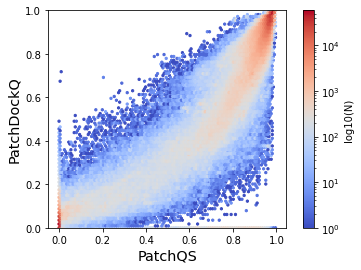

In [18]:
plt.clf()
plt.hexbin('patch_qs', 'patch_dockq', data=df, bins='log', cmap='coolwarm')
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("PatchQS", fontsize="x-large")
plt.ylabel("PatchDockQ", fontsize="x-large")
plt.colorbar(label="log10(N)")
print(df["patch_qs"].corr(df["patch_dockq"], method="pearson"))
plt.savefig("/home/schdaude/workspace/casp15_ema/data/plots/patchqs_vs_patchdockq.png", dpi=300)


(34886, 41)
(26633, 8)


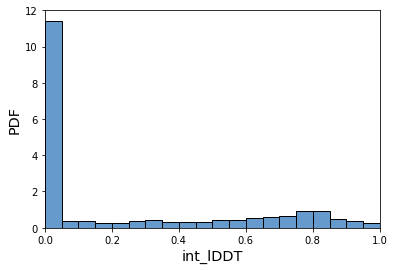

In [19]:
# Executing this code block requires additional data (read: hacky analysis not meant to be reproduced by others)
outlier_df = df[(df["lddt"]>0.8) & (df["patch_dockq"]<0.1)]
print(outlier_df.shape)
outlier_df.head()
outlier_df = outlier_df[["mdl", "trg", "cname", "rnum", "lddt", "patch_dockq", "patch_qs"]]
outlier_df.to_csv("lddt_patchdockq_outliers.csv")
with open("../data/int_lddt.json", 'r') as fh:
    int_lddt_data = json.load(fh)
int_lddt_scores = list()
for mdl, trg, cname, rnum in zip(outlier_df["mdl"], outlier_df["trg"], outlier_df["cname"], outlier_df["rnum"]):
    score = None
    x = mdl + "_" + trg
    if x in int_lddt_data:
        if cname in int_lddt_data[x]:
            if str(rnum) in int_lddt_data[x][cname]:
                score = int_lddt_data[x][cname][str(rnum)]
    if score is None:
        print("missing score for", mdl, trg, cname, rnum)
    int_lddt_scores.append(score)
outlier_df["int_lddt"] = int_lddt_scores        

plt.clf()
#plt.hist('int_lddt', data=df)
plt.hist('int_lddt', data=outlier_df, density=True, bins = 20, color=cblue, linewidth=1.0, edgecolor='k')
plt.xlim((0,1))
#plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("int_lDDT", fontsize="x-large")
plt.ylabel("PDF", fontsize="x-large")
#plt.ylabel("PatchDockQ", fontsize="x-large")
#plt.colorbar(label="log10(N)")
plt.savefig(os.path.join(plot_dir, f"int_lddt_dockq_outlier_hist.png"), dpi=300)
print(outlier_df[outlier_df["int_lddt"]<0.6].shape)


0.8270930771228067


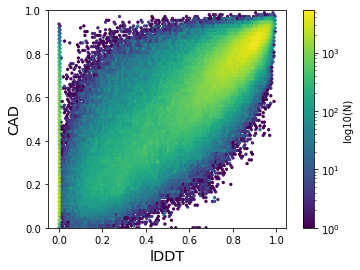

In [20]:
plt.clf()
plt.hexbin('lddt', 'cad', data=df, bins='log')
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("lDDT", fontsize="x-large")
plt.ylabel("CAD", fontsize="x-large")
plt.colorbar(label="log10(N)")
plt.savefig("/home/schdaude/workspace/casp15_ema/data/plots/lddt_vs_cad.png", dpi=300)

print(df["lddt"].corr(df["cad"], method="pearson"))


In [21]:
print("overall ROC AUC")
for g in eval_groups:
    sub_df = df[df[g].isnull()==False]
    print(g, group_mappings[g], roc_auc_score(sub_df["true_interface_residue"], sub_df[g]))

print()
print("avg per target AUC")
for g in eval_groups:
    values = list()
    for trg, trg_file in target_data.items():
        sub_df = df[df["trg"] == trg_file]
        n_exp = sub_df.shape[0]
        n_pred = sub_df[sub_df[g].isnull()==False].shape[0]
        # skip targets that have been filtered out completely in preprocessing (happens for T1192o)
        if n_exp == 0:
            #print(f"no data for {trg}... skip...")
            continue
        # per-target evaluation only assesses targets which fulfill very crude
        # quality filter, e.g. max QS-score of any of the models > 0.6
        if sub_df["global_qs_best"].max() < 0.6:
            #print("skip trg", trg)
            continue
        if float(n_pred)/n_exp >= 0.8:
            sub_df = sub_df[sub_df[g].isnull()==False]
            values.append(roc_auc_score(sub_df["true_interface_residue"], sub_df[g]))
    print(g, group_mappings[g], np.mean(values))
                   

overall ROC AUC
266 ModFOLDdockR 0.7048383035194523
083 ModFOLDdockS 0.6377244639608238
041 ModFOLDdock 0.6482367396774046
248_2 Manifold_2 0.6896184927863911
158 MULTICOM_deep 0.5101829065784143
089 GuijunLab-RocketX 0.6170760453831761
494 Venclovas 0.6981162915262895
468 MASS 0.48048896512224154
426 LAW 0.5477818510807475
168 APOLLO 0.6013279148734387
121 VoroIF 0.6982661828841098
245 FoldEver 0.5466365985070383
101 DLA-Ranker 0.5057641746023845

avg per target AUC
266 ModFOLDdockR 0.7093560379934276
083 ModFOLDdockS 0.6601163091946386
041 ModFOLDdock 0.7340486019845721
248_2 Manifold_2 0.7263466969481455
158 MULTICOM_deep 0.5099516093766723
089 GuijunLab-RocketX 0.6426270509906985
494 Venclovas 0.6750025346189245
468 MASS 0.4871572997863054
426 LAW 0.525480535626454
168 APOLLO 0.5095417698428187
121 VoroIF 0.6751827626052617
245 FoldEver 0.6036719188849242
101 DLA-Ranker 0.4915844548322431


[0.7093560379934276, 'ModFOLDdockR']
[0.6601163091946386, 'ModFOLDdockS']
[0.7340486019845721, 'ModFOLDdock']
[0.7263466969481455, 'Manifold_2']
[0.5099516093766723, 'MULTICOM_deep']
[0.6426270509906985, 'GuijunLab-RocketX']
[0.6750025346189245, 'Venclovas']
[0.4871572997863054, 'MASS']
[0.525480535626454, 'LAW']
[0.5095417698428187, 'APOLLO']
[0.6751827626052617, 'VoroIF']
[0.6036719188849242, 'FoldEver']
[0.4915844548322431, 'DLA-Ranker']
[0.4871572997863054, 'MASS']
[0.4915844548322431, 'DLA-Ranker']
[0.5095417698428187, 'APOLLO']
[0.5099516093766723, 'MULTICOM_deep']
[0.525480535626454, 'LAW']
[0.6036719188849242, 'FoldEver']
[0.6426270509906985, 'GuijunLab-RocketX']
[0.6601163091946386, 'ModFOLDdockS']
[0.6750025346189245, 'Venclovas']
[0.6751827626052617, 'VoroIF']
[0.7093560379934276, 'ModFOLDdockR']
[0.7263466969481455, 'Manifold_2']
[0.7340486019845721, 'ModFOLDdock']


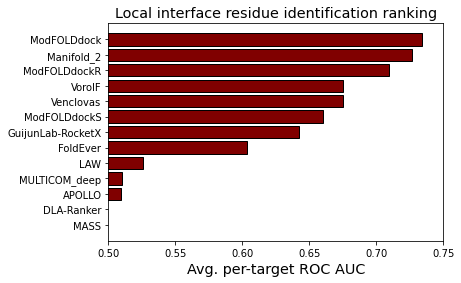

In [22]:
# do ROC AUC of interface probability plot

data = list()

for g in eval_groups:
    values = list()
    for trg, trg_file in target_data.items():
        sub_df = df[df["trg"] == trg_file]
        n_exp = sub_df.shape[0]
        n_pred = sub_df[sub_df[g].isnull()==False].shape[0]
        # skip targets that have been filtered out completely in preprocessing (happens for T1192o)
        if n_exp == 0:
            #print(f"no data for {trg}... skip...")
            continue
        # per-target evaluation only assesses targets which fulfill very crude
        # quality filter, e.g. max QS-score of any of the models > 0.6
        if sub_df["global_qs_best"].max() < 0.6:
            #print("skip trg", trg)
            continue
        if float(n_pred)/n_exp >= 0.8:
            sub_df = sub_df[sub_df[g].isnull()==False]
            values.append(roc_auc_score(sub_df["true_interface_residue"], sub_df[g]))
            #precision, recall, thresholds = precision_recall_curve(sub_df["true_interface_residue"], sub_df[g])
            #values.append(auc(recall, precision))
            #print(group_mappings[g], trg, sub_df[sub_df["true_interface_residue"]==0].shape[0],sub_df[sub_df["true_interface_residue"]==1].shape[0])
    data.append([np.mean(values), group_mappings[g]])
    print(data[-1])
    

data.sort()

for item in data:
    print(item)

y = list(range(len(data)))
labels = [x[1] for x in data]

plt.barh(y, [x[0] for x in data], color=cred, linewidth=1.0, edgecolor='k')
plt.yticks(y, labels)

plt.xlim((0.5, 0.75))

plt.title("Local interface residue identification ranking", fontsize="x-large")
plt.xlabel("Avg. per-target ROC AUC", fontsize="x-large")

plt.savefig(os.path.join(plot_dir, f"local_interface_probability_analysis.png"), dpi=300, bbox_inches="tight")

In [23]:
for trg, trg_file in target_data.items():

    sub_df = df[df["trg"] == trg_file]
    # per-target evaluation only assesses targets which fulfill very crude
    # quality filter, e.g. max QS-score of any of the models > 0.6
    if sub_df["global_qs_best"].max() < 0.6:
        #print("skip trg", trg)
        continue

    sub_df = sub_df[sub_df[g].isnull()==False]
    print(trg)
    print("True values:", sub_df[sub_df["true_interface_residue"]==1].shape[0])
    print("False values:", sub_df[sub_df["true_interface_residue"]==0].shape[0])
    print()

H1106
True values: 0
False values: 0

T1109o
True values: 0
False values: 0

T1110o
True values: 0
False values: 0

H1111
True values: 0
False values: 0

T1113o
True values: 0
False values: 0

H1114
True values: 0
False values: 0

T1115o
True values: 0
False values: 0

T1121o
True values: 6235
False values: 7404

T1123o
True values: 8884
False values: 10243

T1124o
True values: 49152
False values: 7268

T1127o
True values: 38957
False values: 2239

H1129
True values: 11026
False values: 9902

T1132o
True values: 46532
False values: 3989

H1134
True values: 14889
False values: 3046

H1135
True values: 116251
False values: 15430

H1137
True values: 0
False values: 0

H1140
True values: 3388
False values: 6199

H1141
True values: 4937
False values: 4344

H1142
True values: 2448
False values: 6410

H1143
True values: 7175
False values: 2773

H1144
True values: 6177
False values: 5326

H1151
True values: 8157
False values: 2619

T1153o
True values: 3533
False values: 3059

H1157
True values